# $\color{green}{\text{Transfer Learning using Keras and ResNet50:}}$

"*Transfer learning* consists of taking features learned on one problem, and leveraging them on a new, similar problem. Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch." [Keras]

In second part of this project, I have trained a classifier on the Cifar100 dataset but rather than building and training a Convolutional Neural Network model from scratch, I have used ResNet50 model pre-trained on the [ImageNet dataset](http://www.image-net.org/) as a base. Essentially, this has transfer the knowledge accumulated during the training on a large image dataset with 1000 object classes to a similar, more specific problem – classifying 100 different classes of Cifar100. This work has been divided into two sessions of training as follows

1. Feature extraction
2. Fine tunning



***Summary:***

In the previous notebook, I have achieved 65.42% accuracy on test set of CIFAR-100 without tranfer learning which is close to ResNet50. In this notebook, first I have done **feature extraction** with ResNet50 using different deep learning techniques that I have already discussed in part 1 and achieved 75.37% accuracy by freezing the top layers of ResNet50. Later, I have trained the same model again by fine tunning all the layers but got only 1.25% improvement. Finally when I finetuned the model with learning_rate_reduction, the achieved accuracy is improved to 82.19% from 75.37%. In addition, the model has been evaluated on the images that I downloaded from google.


Reference:

[1] [Keras official guide](https://keras.io/guides/transfer_learning/)


[2] [Computer vision Blog](https://stackabuse.com/courses/practical-deep-learning-for-computer-vision-with-python/lessons/image-classification-with-transfer-learning-creating-cutting-edge-cnn-models/#unfreezinglayersfinetuninganetworktrainedwithtransferlearning)

[3] [Machinelearningmaster](https://machinelearningmastery.com)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import densenet
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.metrics import confusion_matrix
from datetime import datetime
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, Dropout,BatchNormalization,GlobalAveragePooling2D
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split


##Cifar100 Dataset split:
The training dataset is consisted of 500 images for 100 classes each.

The testing dataset is consisted of 100 images for 100 classes each.

In [ ]:
# Download dataset of CIFAR-100
from keras.datasets import cifar100
(X_train, y_train), (X_test, Y_test) = cifar100.load_data()


# Import libraries for preprocessing images
from tensorflow.keras.utils import to_categorical

# Normalize images
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

#Let's display basic information about the data to get a sense of what we're dealing with:

# Check the shape of the array
print(f"x_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {X_test.shape}")
print(f"y_test shape: {Y_test.shape}")

# Number of samples in dataset
print(f"Train: {X_train.shape[0]}")
print(f"Test: {X_test.shape[0]}")

# Data format
print(type(X_train))
print(type(y_train))

169017344/169001437 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
Train: 50000
Test: 10000
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


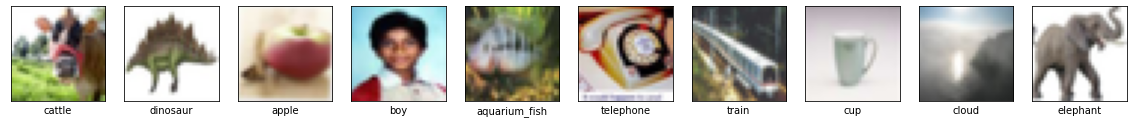

In [ ]:
# Dataset class labels
labels =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
           'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
           'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
           'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']


# Visualize several images and their classes from the training set
# Visualize several images and their classes from the training set
plt.figure(figsize=(20, 3))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap="gray")
    plt.xlabel(labels[y_train[i].astype(int)[0]])
    
plt.show()

    


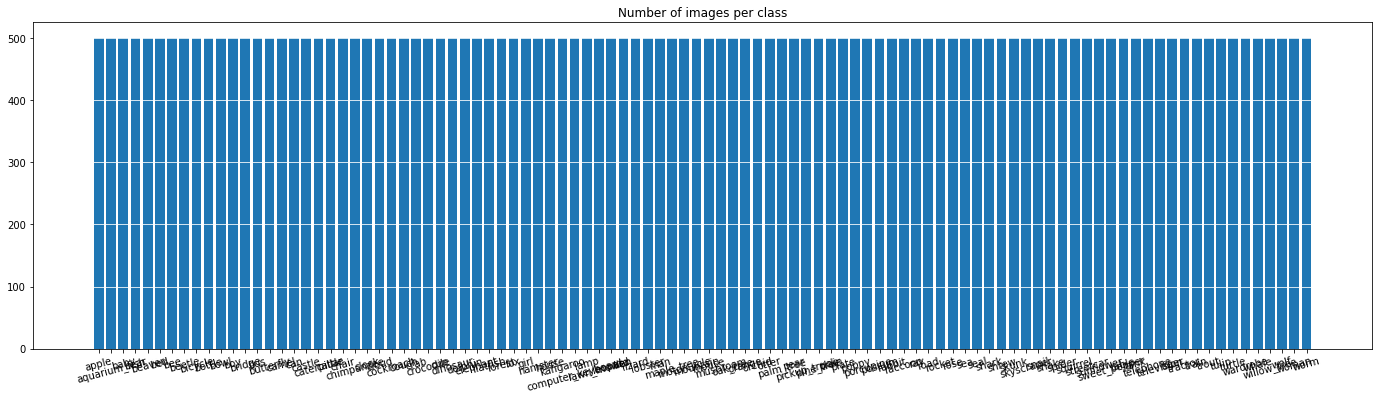

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
ticks = np.arange(len(counts))
plt.figure(figsize=(24,6))
plt.grid(color='w', axis='y')
plt.bar(ticks, counts)
plt.xticks(ticks, labels, rotation=15)
plt.title('Number of images per class')
plt.show()

We can see that the dataset is more or less balanced – there aren't any classes that have substantially more or fewer examples than others.

Let's now shuffle the data and split it into two halves – one for training, and one for validation. Since we don't have a lot of data, let's split it equally so that both training and in validation sets will have 105 images with ~10 images per class.

In [ ]:
#Splitting the train data again - we use the val set as test set and previous test set for final predictions
x_train,x_val,y_train,y_val = train_test_split(X_train, y_train, test_size = 0.2)


# Convert labels to one hot encoding matrix
y_train = to_categorical(y_train, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)


In [ ]:
print(x_train.shape, x_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, Y_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 100) (10000, 100) (10000, 1)


In [ ]:
#Cutout/ Random erasing

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

In [ ]:
train_datagen = ImageDataGenerator( 
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1,  
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,  
        vertical_flip = False,
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False)
)
train_datagen.fit(x_train)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.6, 
    min_lr=1e-6)


es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

#Freeze the top of ResNet50

The BatchNormalization layers is set as trainable, this is needed because when using Frozen model,if the batch statistics (mean/variance) of frozen layers are used and if the target dataset is different from one which was used for training, this will result in degrading of accuracy as stated on the official guide of keras.

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

$\color{green}{\text{Problem:}}$ The Cifar images are of the shape 32,32,3 and resnet model is trained on images of 224,224,3. Resizing these images locally is a costly operation and I eventually ran out of memory many a times

Used Solution : Keras provides an upsampling layer – called UpSampling2D – which allows to perform upsampling operation within neural networks

32 * 7 = 224

Reference: https://machinelearningmastery.com


In [ ]:
model=tf.keras.models.Sequential()
model.add(UpSampling2D(size=(7, 7),interpolation='bilinear'))
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


In [ ]:

model.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:

history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size = 128),
    validation_data = (x_val, y_val),
    epochs = 70,
    verbose = 1,
    callbacks = [learning_rate_reduction, es]
)


Epoch 1/70
313/313 [==============================] - 333s 1s/step - loss: 4.0729 - accuracy: 0.1136 - val_loss: 6.7361 - val_accuracy: 0.0088 - lr: 1.0000e-04
Epoch 2/70
313/313 [==============================] - 322s 1s/step - loss: 2.9720 - accuracy: 0.2871 - val_loss: 5.9435 - val_accuracy: 0.0150 - lr: 1.0000e-04
Epoch 3/70
313/313 [==============================] - 323s 1s/step - loss: 2.5160 - accuracy: 0.3734 - val_loss: 2.9345 - val_accuracy: 0.2925 - lr: 1.0000e-04
Epoch 4/70
313/313 [==============================] - 323s 1s/step - loss: 2.2591 - accuracy: 0.4250 - val_loss: 1.7808 - val_accuracy: 0.5208 - lr: 1.0000e-04
Epoch 5/70
313/313 [==============================] - 322s 1s/step - loss: 2.0504 - accuracy: 0.4674 - val_loss: 1.5791 - val_accuracy: 0.5684 - lr: 1.0000e-04
Epoch 6/70
313/313 [==============================] - 323s 1s/step - loss: 1.9133 - accuracy: 0.5013 - val_loss: 1.4965 - val_accuracy: 0.5913 - lr: 1.0000e-04
Epoch 7/70
313/313 [====================

In [ ]:
# Plot function for visualisation training process
import matplotlib.pyplot as plt

def training_plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

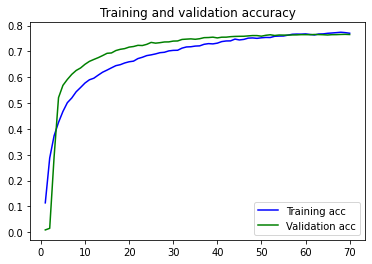

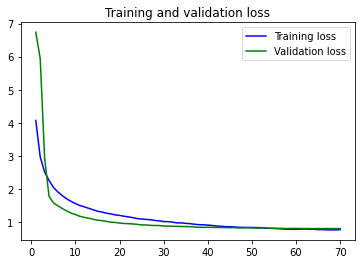

In [ ]:
# Visualize training process
training_plot(history)

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = Y_test.ravel()
print(y_pred.shape,y_true.shape)

(10000,) (10000,)


In [ ]:
loss_val, acc_val = model.evaluate(x_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

313/313 [==============================] - 29s 92ms/step - loss: 0.8065 - accuracy: 0.7651
Validation: accuracy = 0.765100  ;  loss_v = 0.806480


In [ ]:
print("Testing Accuracy: ", accuracy_score(y_true,y_pred))


Testing Accuracy:  0.7537


In [ ]:
model.save("ResNet50FeatureExtractor.h5")

In [ ]:
pwd!

'/content'

In [ ]:
cm = confusion_matrix(y_true,y_pred)
cm

In [ ]:
# Name of all classes in CIFAR-100
classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale', 
'aquarium' ,'fish', 'ray', 'shark', 'trout', 
'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', 
'bottles', 'bowls', 'cans', 'cups', 'plates', 
'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers', 
'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 
'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 
'bear', 'leopard', 'lion', 'tiger', 'wolf', 
'bridge', 'castle', 'house', 'road', 'skyscraper', 
'cloud', 'forest', 'mountain', 'plain', 'sea', 
'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', 
'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 
'crab', 'lobster', 'snail', 'spider', 'worm', 
'baby', 'boy', 'girl', 'man', 'woman', 
'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 
'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 
'maple', 'oak', 'palm', 'pine', 'willow', 
'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train', 
'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']

[[91  0  0 ...  0  0  0]
 [ 0 84  0 ...  0  0  0]
 [ 0  1 71 ...  0  5  0]
 ...
 [ 0  0  0 ... 76  0  0]
 [ 0  0  6 ...  0 52  0]
 [ 0  0  0 ...  0  0 81]]


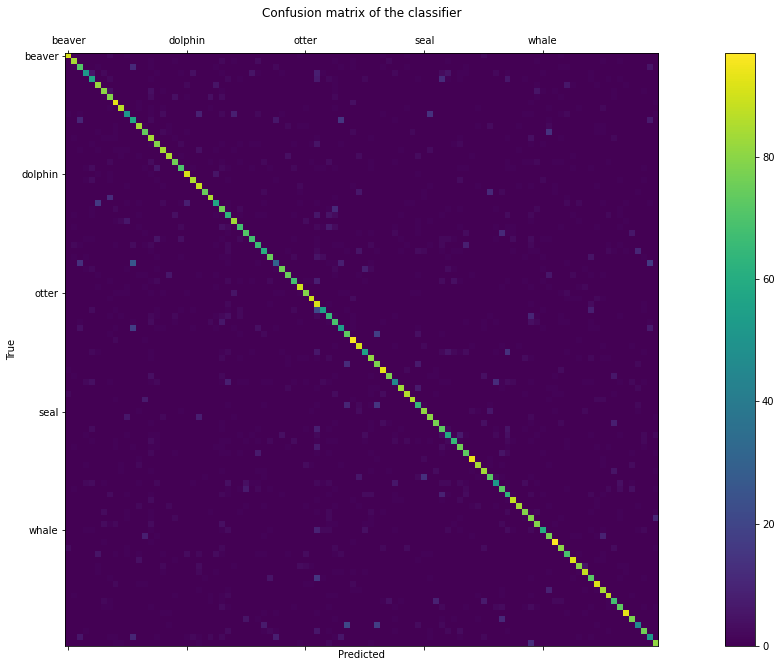

In [ ]:
#Plot the confusion matrix
import matplotlib.pyplot as plt
#print(cm)
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(211)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#Fine tuning all layers :
Now the model is train again with the all layers but this time I have freezed the batchnormalization layers so that the pervious learnt features on cifar100 will not be updated.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow import keras
loaded_model = keras.models.load_model('./drive/MyDrive/input/ResNet50FeatureExtractor.h5')


In [ ]:
for layer in loaded_model.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.6, 
    min_lr=1e-6)


es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

In order to ensure the trainability, I have recompiled the model. 


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath='ResNet50_transfer_learning_finetuned.h5', save_best_only=True)

# Recompile after turning to trainable
loaded_model.compile(loss="categorical_crossentropy", 
                  optimizer=optimizer, 
                  metrics=["accuracy"])

history = loaded_model.fit(
    train_datagen.flow(x_train, y_train, batch_size = 128),
    validation_data = (x_val, y_val),
    epochs = 35,
    verbose = 1,
    callbacks = [checkpoint, es, learning_rate_reduction]
)


Epoch 1/35
313/313 [==============================] - 463s 1s/step - loss: 0.9516 - accuracy: 0.7182 - val_loss: 0.7494 - val_accuracy: 0.7683 - lr: 1.0000e-04
Epoch 2/35
313/313 [==============================] - 456s 1s/step - loss: 0.7168 - accuracy: 0.7831 - val_loss: 0.8148 - val_accuracy: 0.7622 - lr: 1.0000e-04
Epoch 3/35
313/313 [==============================] - 454s 1s/step - loss: 0.5993 - accuracy: 0.8133 - val_loss: 0.8927 - val_accuracy: 0.7577 - lr: 1.0000e-04
Epoch 4/35
313/313 [==============================] - 456s 1s/step - loss: 0.5191 - accuracy: 0.8382 - val_loss: 0.6849 - val_accuracy: 0.8006 - lr: 1.0000e-04
Epoch 5/35
313/313 [==============================] - 456s 1s/step - loss: 0.4516 - accuracy: 0.8580 - val_loss: 0.8673 - val_accuracy: 0.7600 - lr: 1.0000e-04
Epoch 6/35
313/313 [==============================] - 455s 1s/step - loss: 0.4039 - accuracy: 0.8730 - val_loss: 0.7618 - val_accuracy: 0.7935 - lr: 1.0000e-04
Epoch 7/35
313/313 [====================

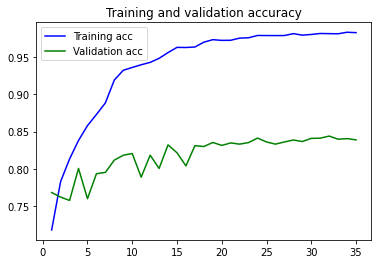

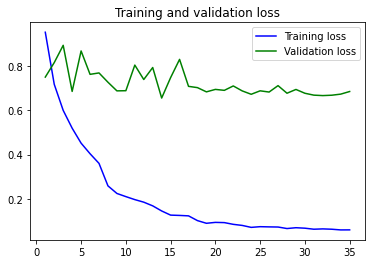

In [ ]:
# Visualize training process
training_plot(history)

In [ ]:
y_pred = np.argmax(loaded_model.predict(X_test), axis=-1)
y_true = Y_test.ravel()
print(y_pred.shape,y_true.shape)

(10000,) (10000,)


In [ ]:
loss_val, acc_val = loaded_model.evaluate(x_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

313/313 [==============================] - 28s 88ms/step - loss: 0.6844 - accuracy: 0.8389
Validation: accuracy = 0.838900  ;  loss_v = 0.684436


##Testing accuracy after fine tuning

In [ ]:
print("Testing Accuracy: ", accuracy_score(y_true,y_pred))

Testing Accuracy:  0.8219


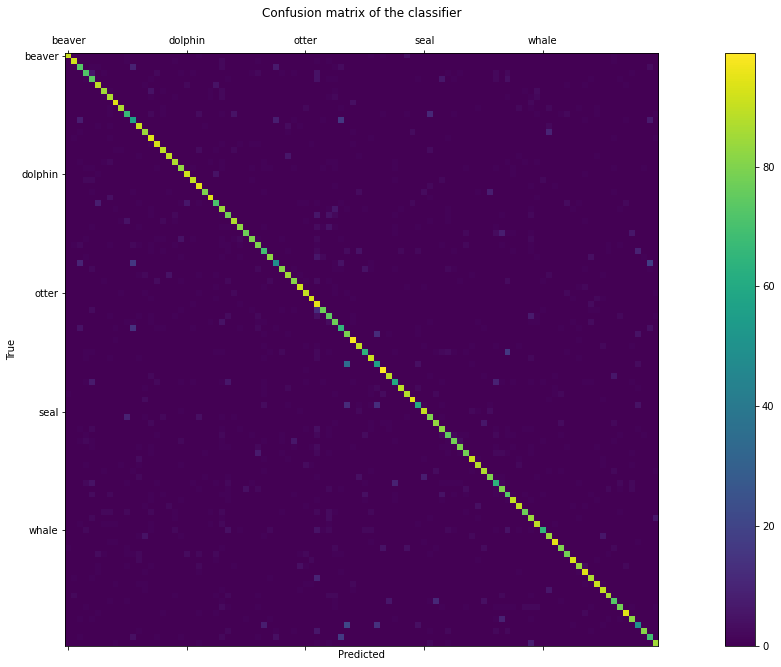

In [ ]:
cm = confusion_matrix(y_true,y_pred)
#Plot the confusion matrix
import matplotlib.pyplot as plt
#print(cm)
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(211)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#Conclusion:
The accuracy achieved by feature extraction is 75.37% on testing dataset. When I load this model again and fine tune it using all the layers of ResNet50, the accuracy has been improved to 82.19.

It has been stated that;

If you can squeeze out an additional 1% in accuracy, it might not sound like a lot, but consider the other end of the trade. If your model has a 95% accuracy on 100 samples, it misclassified 5 samples. If you up that to 96% accuracy, it misclassified 4 samples.

**The 1% of accuracy translates to a 25% decrease in false classifications.**[2]

#Note:
The training time involved in this project took alot of days. The server of Cifar100 was also down due to power outage so I wasted almost two days because of that. I can improve this model futher and wanted to investigate a few more methods but due to time and limitation of resources I am not do this in given period of time. Even I have also tried to optimize the training time but it was not that much effective.

#Evaluate Model on Custom Images

In [ ]:
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

model = load_model('/content/drive/MyDrive/input/ResNet_transfer_learning_finetuned.h5')

In [ ]:
# Get the names of the class labels
labels =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
           'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
           'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
           'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

labels_names = []
for i in range(len(labels)):
    labels_names += [i]
    
reverse_mapping = dict(zip(labels_names, labels)) 

def mapper(value):
    return reverse_mapping[value]

# Pre-process image
image_1 = load_img('./drive/MyDrive/input/image1.jpeg', target_size=(32, 32))
image_1 = img_to_array(image_1) 
image_1 = image_1 / 255.0
prediction_image_1 = np.array(image_1)
prediction_image_1 = np.expand_dims(image_1, axis=0)

# Get prediction
prediction_1 = model.predict(prediction_image_1)
value_1 = np.argmax(prediction_1)
name_1 = mapper(value_1)
print(f'Prediction is {name_1}.')

Prediction is clock.


In [ ]:

# Pre-process one more image
image_2 = load_img('./drive/MyDrive/input/image2.jpeg', target_size=(32, 32))
image_2 = img_to_array(image_2) 
image_2 = image_2 / 255.0
prediction_image_2 = np.array(image_2)
prediction_image_2 = np.expand_dims(image_2, axis=0)
# Get prediction
prediction_2 = model.predict(prediction_image_2)
value_2 = np.argmax(prediction_2)
name_2 = mapper(value_2)
print(f'Prediction is {name_2}.')

Prediction is table.
